In [163]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json

In [103]:
data = pd.read_excel("./data/Батч 1.xlsx")
for i in range(2, 6):
    data = data.append(pd.read_excel("./data/Батч {}.xlsx".format(i)), ignore_index=True)
    

In [212]:
# здесь нет бандеролей
del data["бандероль"]
del data["с объявл. ценностью"]
del data["с налож. платежом"]

In [249]:
data['сумма ОЦ (руб)'].fillna(0, inplace=True)
data['сумма НП (руб)'].fillna(0, inplace=True)
data.fillna(False, inplace=True)

In [219]:
data.head()

,hid,дата оформления,индекс отправителя,индекс получателя,вес (гр),"стоимость (руб,коп)",сумма ОЦ (руб),сумма НП (руб),безбланковая отправка,ускоренное,международное,с описью вложений,отметка 'Осторожно',sms для отправителя,sms для получателя
0,17279630-2e29-4a0d-8f96-f3c932e6bbcb,2020-07-05 00:00:26.036000,109469,107241,100.0,173.0,0.0,0.0,False,True,False,False,False,False,False
1,16971e43-728a-4f66-a93c-3678aa8433cd,2020-07-05 00:03:17.229000,390039,125284,1100.0,238.0,0.0,0.0,True,False,False,False,False,False,False
2,16d739fa-ca72-4b12-b8a1-ae5d91df945f,2020-07-05 00:11:47.671000,111250,670033,100.0,173.0,0.0,0.0,True,True,False,False,False,False,False
3,8182829,2020-07-05 00:12:50.965000,105173,183035,2262.0,363.0,0.0,0.0,False,False,False,False,False,False,False
4,1645b790-f6f9-4c3f-b92b-eae34e781784,2020-07-05 00:13:05.474000,195197,184209,1905.0,338.0,0.0,0.0,False,False,False,False,False,False,False


In [159]:
def append_region_id(data, index_column):
    # определяем почтовый район -- первые 3 цифры индекса
    res = data.copy()
    res["район {}".format(index_column.split()[1])] = [str(x)[:3] for x in res[index_column]]
    return res

In [160]:
def split_databases(data):
    # попытка определить из какой базы строка
    res = data.copy()
    res["secondDB"] = [isinstance(x, int) for x in res["hid"]]
    return res

In [245]:
def add_region_and_city_name(data):
    # получаем названия города и региона по индексу
    res = data.copy()
    with open('data/p2a.json', encoding='utf8') as f:
        p2a = json.load(f)
    
    for point in ['отправителя', 'получателя']:
        res['регион {}'.format(point)] = [p2a.get(x)['region']
                                          if p2a.get(x) else str(x)[:3]
                                          for x in res['индекс {}'.format(point)].astype(str)]
        res['город {}'.format(point)] = [(p2a.get(x)['subregion']
                                    if 'subregion' in p2a.get(x)
                                    else p2a.get(x)['locality']
                                    if 'locality' in p2a.get(x)
                                    else p2a.get(x)['region'])
                                    if p2a.get(x) else str(x)[:3]
                                    for x in res['индекс {}'.format(point)].astype(str)]
        
        res.dropna(subset=['город {}'.format(point)], inplace=True)
    return res
    

In [250]:
new_data = append_region_id(data, "индекс отправителя")
new_data = append_region_id(new_data, "индекс получателя")
new_data = split_databases(new_data)

new_data_regions = add_region_and_city_name(new_data)

In [274]:
cnts_sends = cnts_per_user.value_counts()
cnts_send_filtered = cnts_sends
# cnts_send_filtered.plot(kind='bar', figsize=(25, 10))
cnts_per_user = new_data['hid'].value_counts()

# сколько пользователей обеспечивают T часть оборота
T = 0.1

res = 0.0
cnt_p = 0
for k in cnts_send_filtered.keys()[-1::-1]:
    res += k * cnts_send_filtered[k]
    cnt_p += cnts_send_filtered[k]
    if res/new_data.shape[0] > T:
        break
        
print(cnt_p)

140


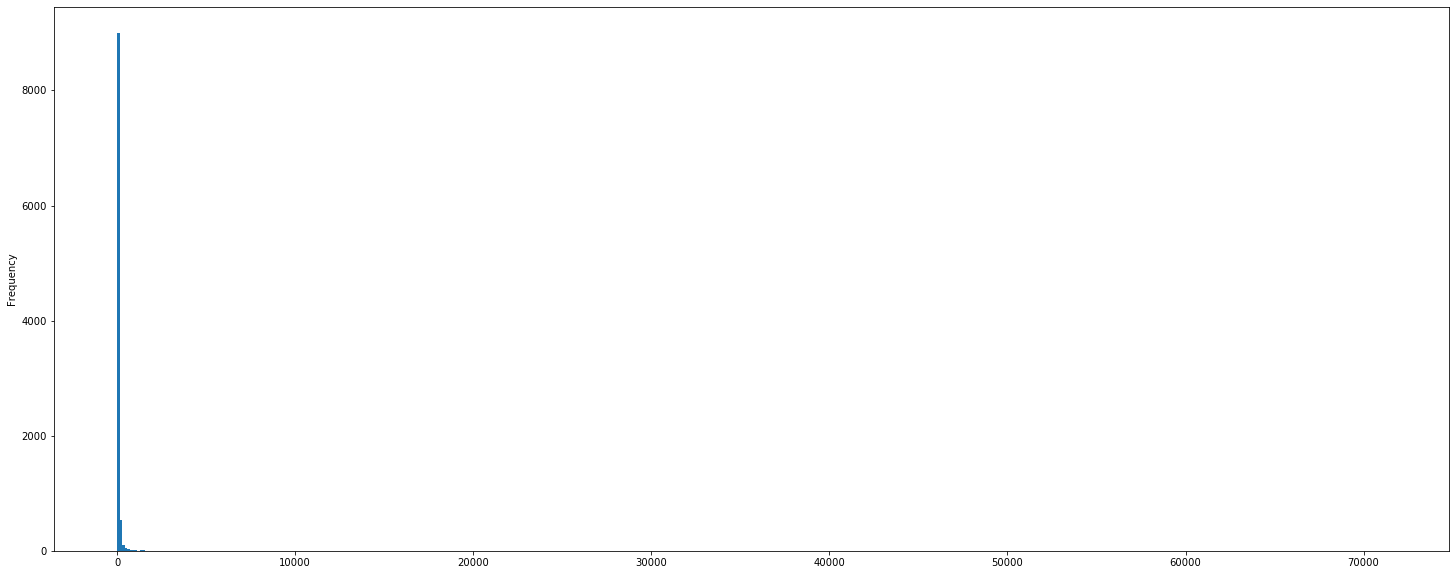

In [205]:
# Распределение весов
new_data['вес (гр)'].value_counts().plot(kind='hist', figsize=(25, 10), bins=500)

In [266]:
new_data[new_data["сумма НП (руб)"] > 0].shape[0]

121727

In [268]:
False > 0

False

In [272]:
915/new_data[(new_data["сумма НП (руб)"] > 0) & (new_data["с описью вложений"]==False)].shape[0]

0.007838199013157895

In [236]:
with open("cities_send.txt", "w", encoding='utf8') as f:
    f.write(new_data_regions['город отправителя'].value_counts().to_string())
with open("cities_get.txt", "w", encoding='utf8') as f:
    f.write(new_data_regions['город получателя'].value_counts().to_string())

In [252]:
user_df = pd.DataFrame()
for value, df in new_data_regions.groupby("hid"):
    user_data = {
        'hid': value,
        'count': df.shape[0],
        'dif_index_count': len(set(df['индекс отправителя'])),
        'avg_weight': np.mean(df['вес (гр)']),
        'avg_cost': np.mean(df['стоимость (руб,коп)']),
        'avg_oc': np.mean(df['сумма ОЦ (руб)']),
        'avg_np': np.mean(df['сумма НП (руб)']),
        'no_blank_rate': len(df[df['безбланковая отправка']])/df.shape[0],
        'fast_rate': len(df[df['ускоренное']])/df.shape[0],
        'dangerouse_rate': len(df[df["отметка 'Осторожно'"]])/df.shape[0],
        'sms_send_rate': len(df[df["sms для отправителя"]])/df.shape[0],
        'sms_get_rate': len(df[df["sms для получателя"]])/df.shape[0],
        
    }
    user_df = user_df.append(user_data, ignore_index=True)

In [255]:
user_df.head()

,avg_cost,avg_np,avg_oc,avg_weight,count,dangerouse_rate,dif_index_count,fast_rate,hid,no_blank_rate,sms_get_rate,sms_send_rate
0,251.736842,0.000000,0.000000,330.526316,19.0,0.0,1.0,0.210526,300950,1.0,0.0,0.0
1,230.000000,0.000000,0.000000,190.000000,1.0,0.0,1.0,1.000000,345420,0.0,0.0,0.0
2,272.412692,428.974359,428.974359,263.076923,78.0,0.0,1.0,0.000000,345660,1.0,0.0,0.0
3,179.000000,0.000000,0.000000,65.000000,1.0,0.0,1.0,1.000000,345914,1.0,0.0,0.0
4,356.200000,0.000000,0.000000,300.000000,1.0,1.0,1.0,0.000000,345920,0.0,0.0,0.0


In [259]:
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE

In [262]:
import seaborn as sns

In [257]:
del user_df['hid']

In [258]:
normalize(user_df)

array([[6.05265839e-01, 0.00000000e+00, 0.00000000e+00, ...,
        2.40435938e-03, 0.00000000e+00, 0.00000000e+00],
       [7.70948758e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.78664401e-01, 5.96291301e-01, 5.96291301e-01, ...,
        1.39003949e-03, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.02348570e-01, 0.00000000e+00, 0.00000000e+00, ...,
        2.21055227e-04, 0.00000000e+00, 0.00000000e+00],
       [5.55464461e-01, 0.00000000e+00, 0.00000000e+00, ...,
        1.66306725e-03, 0.00000000e+00, 0.00000000e+00],
       [7.43950932e-01, 0.00000000e+00, 0.00000000e+00, ...,
        2.22739800e-03, 0.00000000e+00, 0.00000000e+00]])

In [260]:
tsne = TSNE()

In [261]:
udf_viz = tsne.fit_transform(user_df)

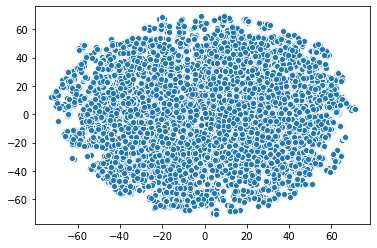

In [264]:
sns.scatterplot(x=udf_viz[:,0], y=udf_viz[:,1])